# Matched VE Analysis: Updated Pipeline with Z-Scored Outcome Measures

In [1]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats

In [3]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 

    exclude: list of subject IDs that should be excluded from the final df 

    """
    
    exclude = []
    
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                # do NOT include subject IDs that have been flagged 
                subjID = df.subjID.unique()[0]
                if subjID not in exclude:
                    data.append(df)

        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
    
    print('Number of participants before cleaning: ', len(input_frame.subjID.unique()))

 
    return input_frame


def feet_to_meters(ft):
    """
    Args: 
        ft = float value in feet 
        
    returns:
        m = float value converted to meters 
    """
    m = ft * 0.3048
    return m

def getUnitConveredData(datafolder):
    input_data = combineCSVs(datafolder) # combine CSVs from all participants 
    
    for idx, row in input_data.iterrows():
        unit = row['unitSelection']
        # if estimate was made in feet, convert to meters 
        if unit == 'feet':
            estim_ft = row['depth_estimate']
            estim_m = feet_to_meters(estim_ft)
            # update depth estimates in existing dataframe
            input_data.at[idx, 'depth_estimate'] = estim_m
            # update units in existing dataframe
#             input_data.at[idx, 'unitSelection'] = 'meters'
    
    return input_data

def cleanAgeResponses(datafolder):
    input_data = getUnitConveredData(datafolder)
    
    for idx, row in input_data.iterrows():
        age = row['age']
        # if year of birth was given, convert to age
        if age > 100:
            actual_age = 2021-age
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age
        # participants must be over 18 so age reports below 18 are junk 
        if age < 18:
            actual_age = None
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age    
        if 90 < age < 100:
            actual_age = None
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age 
    
    return input_data    
    

def removeMissedTrials(datafolder):
    """
    Participants were told that if they missed a trial, to respond '0'.
    This function removes those trials, and keeps track of:
    (1) How many missed trials per participant
    (2) Number of missed trials per duration 
    (3) Number of missed trials per sequence 
    """
    input_data = cleanAgeResponses(datafolder)
    
    missedTrials_participants = {}
    missedTrials_durations = {}
    missedTrials_sequences = {}
    
    
    for idx, row in input_data.iterrows():
        estimate = row['depth_estimate']
        if estimate == 0.0:
            subjID = row['subjID']
            duration = row['duration']
            sequenceName = row['sequenceName']
            
            if subjID not in missedTrials_participants:
                missedTrials_participants[subjID] = 1
            else:
                missedTrials_participants[subjID] += 1

            if duration not in missedTrials_durations:
                missedTrials_durations[duration] = 1
            else:
                missedTrials_durations[duration] += 1
            
            if sequenceName not in missedTrials_sequences:
                missedTrials_sequences[sequenceName] = 1
            else:
                missedTrials_sequences[sequenceName] += 1
            
#             print(subjID, duration, sequenceName)
            
            # remove trials with depth estimate = 0 
            input_data.drop(idx, inplace=True)
    
    # remove participants data if the participant's missed trial count is 10% or more of num_trials
    threshold = math.floor(192 * 0.1)
#     print("Missing Trial Count Threshold: ", threshold)
    remove_ids = []
    for key in missedTrials_participants:
        if missedTrials_participants[key] >= threshold:
            remove_ids.append(key)
    print("Number of participants with 10% or more missed trials: ", len(remove_ids))

    for index, row in input_data.iterrows():
        if row['subjID'] in remove_ids:
            input_data.drop(index, inplace=True)

    # Note if a particular participant, duration, or sequence has maximum missing trials
    # ** If the participant had no missed trials, then ID will not show up in dict 
#     print("Missed Trials")
#     print(missedTrials_participants)
#     print(missedTrials_durations)
#     print(missedTrials_sequences)

    
    return input_data


In [4]:
# path = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_MTurk/data'

# path = "/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/BNav_EC2/DepthDuration/v2_depth_duration_MTurk/data"

path = '/Users/prachi/Documents/depth_duration/target_at_center/january2022_data/VE_data'

missed_trial_cleaned_data = removeMissedTrials(path)

Number of participants before cleaning:  125
Number of participants with 10% or more missed trials:  4


#### Distribution of Unit Preferences

In [5]:
pre_unitconversion_data = combineCSVs(path)

Number of participants before cleaning:  125


In [6]:
subject_ids_pre_cleaning = pre_unitconversion_data.subjID.unique()
subj_units = {}
meters_count = 0
feet_count = 0
for subj in subject_ids_pre_cleaning:
    subj_df = pre_unitconversion_data.loc[pre_unitconversion_data['subjID'] == subj]
    unit = subj_df.unitSelection.unique()
    subj_units[subj] = unit[0]
    if unit == "feet":
        feet_count += 1
    if unit == "meters":
        meters_count += 1
    
meters_count, feet_count

(30, 95)

### In this version, the RT exclusion criterion is the same for all participants [1000 ms, 10000 ms]


In [7]:

def RT_Cleaning(df):
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        # calculate subject's average trial RT 
        average_trial_RT = subj_df["trial_RT"].mean()
        std_trial_RT = subj_df["trial_RT"].std()
#         outlier_range = [(average_trial_RT - (3*std_trial_RT)), (average_trial_RT + (3*std_trial_RT))] 
#         outlier_range = [1000, (average_trial_RT + (3*std_trial_RT))] 
        outlier_range = [1000, 10000]

        for idx, row in subj_df.iterrows():
            RT = row["trial_RT"]
            if RT < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                
        threshold = math.floor(192 * 0.1)
        if count >= threshold:
            remove.append(subj)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
            
    print("Number of Participants with 10% or more trials outside their RT range: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2



In [8]:
RT_cleaned_data = RT_Cleaning(missed_trial_cleaned_data)

Number of Participants with 10% or more trials outside their RT range:  13


### Skip Participant Outlier Removal and Average Estimate Cleaning

In [9]:
def participant_Outlier_Removal(df):
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    remove = []
    
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 

        # calculate subject's average trial RT 
        average = subj_df["depth_estimate"].mean()
        std = subj_df["depth_estimate"].std()
        outlier_range = [(average - (3*std)), (average + (3*std))]
        
        for idx, row in subj_df.iterrows():
            estim = row["depth_estimate"]
            if estim < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            if estim > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                
        threshold = math.floor(192 * 0.1)
        if count >= threshold:
            remove.append(subj)
         
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
        
    print("Number of Participants with 10% or more outlier trials: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2



In [10]:
outlier_cleaned_data = participant_Outlier_Removal(RT_cleaned_data)

Number of Participants with 10% or more outlier trials:  0


In [12]:
# outlier_cleaned_data

In [11]:
def getActualDepthAverage(df):
    """
    True average of target depths in the stimuli
    """
    
    avg_actual = np.mean(np.array(df['actual_depth']))
    
    return avg_actual

def participantAverageEstim_Cleaning(df):
    true_average = getActualDepthAverage(df)
    octave_window = [true_average/4, true_average * 4]
    print(true_average, octave_window)
    
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        # calculate subject's average depth estimation  
        avg = subj_df['depth_estimate'].mean()
        if avg < octave_window[0]:
            remove.append(subj)
        if avg > octave_window[1]:
            remove.append(subj)
    
    print("Avg Estim Cleaning: Number of Participants Removed", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
    return df 



In [12]:
avg_estim_cleaned_data = participantAverageEstim_Cleaning(outlier_cleaned_data)

3.012648374164151 [0.7531620935410378, 12.050593496656605]
Avg Estim Cleaning: Number of Participants Removed 8


In [15]:
# avg_estim_cleaned_data

In [10]:
def repeatResponses_Cleaning(df):
    """
    Some participants gave'junk data' - same number repeated for many trials 
    Count the frequency of unique responses entered by the participant. 
    If you look at the maximum number of repeats and/or the number of unique responses / 48 per participant you will find our vandals.
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    max_repeats_distribution = []
    num_unique_responses_distribution = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        # ideally, the max repeats and num_unique_responses should be ~ 48 since there are 48 imgs at each depth bin 
        count_depth_estimates = subj_df['depth_estimate'].value_counts()
        num_unique_responses = len(count_depth_estimates)
        num_unique_responses_distribution.append(num_unique_responses)
        max_repeats = count_depth_estimates.max()
        max_repeats_distribution.append(max_repeats)
        if num_unique_responses < 6:
            remove.append(subj)
    
    avg_max_repeats = np.array(max_repeats_distribution).mean()
    std_max_repeats = np.array(max_repeats_distribution).std()
    
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_depth_estimates = subj_df['depth_estimate'].value_counts()
        max_repeats = count_depth_estimates.max()

        outlierrange = [avg_max_repeats - (3*std_max_repeats), avg_max_repeats + (3*std_max_repeats)]
        if max_repeats < outlierrange[0]:
            if subj not in remove:
                remove.append(subj)
        if max_repeats > outlierrange[1]:
            if subj not in remove:
                remove.append(subj)
                
    print("Number of participants removed: repeat responses: ", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)

    return df, max_repeats_distribution, num_unique_responses_distribution



In [11]:
repeat_resp_cleaned_data, max_repeats_distrib, num_unique_distrib = repeatResponses_Cleaning(RT_cleaned_data)

Number of participants removed: repeat responses:  3


In [12]:
# repeat_resp_cleaned_data

In [13]:
def finalTrialCountCheck(df):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        threshold_trials_remaining = 192 - math.floor(192 * 0.1)

        if count_trials <= threshold_trials_remaining:
            remove.append(subj)
            
    print("Number of Participants with >= 10% trials removed: ", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
        
    print("Number of participants left: ",len(df.subjID.unique()))
    
    return df

In [14]:
cleaned_data = finalTrialCountCheck(repeat_resp_cleaned_data)

Number of Participants with >= 10% trials removed:  3
Number of participants left:  102


In [21]:
# find repeat sequences due to mturk glitch (so that N=192, as pre-registered) --> remove subject that was collected last 

all_subjects = cleaned_data.subjID.unique()
all_sequences = cleaned_data.sequenceName.unique()
for seq in all_sequences:
    seq_df = cleaned_data.loc[cleaned_data['sequenceName']== seq]
    seq_subjs = seq_df.subjID.unique()
    if len(seq_subjs) > 1:
        print(seq_subjs)
    

[751172 698911]
[838133 675375]
[761733 875825]
[381112 808337]
[567839 467334]
[152222 257518]
[911073 679064]
[551476 329210]
[189255 366614]
[512694 477529]


# of subjs with 192 trials:  18
Average # of trials:  186


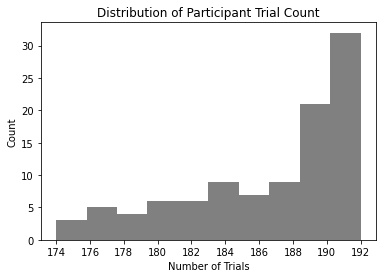

In [36]:
# subselect subjects that have 192 trials (none removed in outlier cleaning)

completeData_subjects = []
cD_distribution = []
all_subjIDs = cleaned_data.subjID.unique()
    
for subj in all_subjIDs:
    subj_df = cleaned_data.loc[cleaned_data['subjID'] == subj]
    count_trials = len(subj_df.index)
    cD_distribution.append(count_trials)
    if count_trials == 192:
        completeData_subjects.append(subj)

print('# of subjs with 192 trials: ',len(completeData_subjects))
print('Average # of trials: ', int(np.mean(cD_distribution)))

plt.hist(cD_distribution, color='gray')
plt.xticks(np.arange(174, 194, 2))
plt.title('Distribution of Participant Trial Count')
plt.xlabel('Number of Trials')
plt.ylabel('Count')
plt.show()

In [18]:
# remove participants
remove = []
for index, row in cleaned_data.iterrows():
    if row['subjID'] in remove:
        cleaned_data.drop(index, inplace=True)

In [37]:
final_data = cleaned_data.copy(deep=True)

In [38]:
len(final_data.subjID.unique())

102

### Z-Score Depth Estimates and RT 

In [80]:
def zscored_outcomes(df):
    '''
    z-score depth estimates and RTs:
        for each subj calculate their avg and std 
        zscored = (estim - subj avg)/subj std
    '''
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    df2_list = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        final_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        # Z-Score depth estimates
        average_estim = subj_df["depth_estimate"].mean()
        std_estim = subj_df["depth_estimate"].std()
        subj_depth_estimates = np.array(list(subj_df["depth_estimate"]))
        zscored_subj_depth_estimates = (subj_depth_estimates - average_estim)/std_estim
        final_subj_df.replace(subj_depth_estimates, zscored_subj_depth_estimates, inplace=True)
        # Z-Score RT
        average_RT = subj_df["trial_RT"].mean()
        std_RT = subj_df["trial_RT"].std()
        subj_RTs = np.array(list(subj_df["trial_RT"]))
        zscored_subj_RTs = (subj_RTs - average_RT)/std_RT
        final_subj_df.replace(subj_RTs, zscored_subj_RTs, inplace=True)
        df2_list.append(final_subj_df)
    
    df2 = pd.concat(df2_list)    

    return df2
     

In [81]:
zscored_data = zscored_outcomes(final_data)

In [82]:
zscored_data['trial_RT']

0        1.163965
1        1.579330
2        5.234133
3        1.522319
4        1.980442
           ...   
23995   -0.022848
23996    0.418624
23997   -0.402140
23998    0.406188
23999   -0.333743
Name: trial_RT, Length: 19050, dtype: float64

In [39]:
average_depth_estimate = np.array(final_data['depth_estimate']).mean()
average_depth_estimate

7.6695969721784785

In [26]:
sampled_urls = final_data.url.unique()
sampled_urls

array(['http://54.173.230.142/FacialAge/BNav_EC2/DepthDuration/v2_depth_duration_MTurk/v2_DepthDuration_HTML.html#157',
       'http://54.173.230.142/FacialAge/BNav_EC2/DepthDuration/v2_depth_duration_MTurk/v2_DepthDuration_HTML.html#167',
       'http://54.173.230.142/FacialAge/BNav_EC2/DepthDuration/v2_depth_duration_MTurk/v2_DepthDuration_HTML.html#174',
       'http://54.173.230.142/FacialAge/BNav_EC2/DepthDuration/v2_depth_duration_MTurk/v2_DepthDuration_HTML.html#179',
       'http://54.173.230.142/FacialAge/BNav_EC2/DepthDuration/v2_depth_duration_MTurk/v2_DepthDuration_HTML.html#158',
       'http://54.173.230.142/FacialAge/BNav_EC2/DepthDuration/v2_depth_duration_MTurk/v2_DepthDuration_HTML.html#169',
       'http://54.173.230.142/FacialAge/BNav_EC2/DepthDuration/v2_depth_duration_MTurk/v2_DepthDuration_HTML.html#114',
       'http://54.173.230.142/FacialAge/BNav_EC2/DepthDuration/v2_depth_duration_MTurk/v2_DepthDuration_HTML.html#148',
       'http://54.173.230.142/FacialAge/

#### Unit Distribution 

In [41]:
final_subjects = final_data.subjID.unique()
num_feet = 0
num_meters = 0
feet_subjects = []
for subj in final_subjects:
    unit = subj_units[subj]
    if unit == 'feet':
        num_feet += 1
        feet_subjects.append(subj)
    else:
        num_meters += 1

num_feet, num_meters

(85, 17)

Filter data by removing participants that used meters 

In [28]:
# for subj in final_subjects:
#     if subj not in feet_subjects:
#         print(subj)
#         final_data.drop(final_data.loc[final_data['subjID']==subj].index, inplace=True)

In [40]:
len(final_data.subjID.unique())

102

#### Age

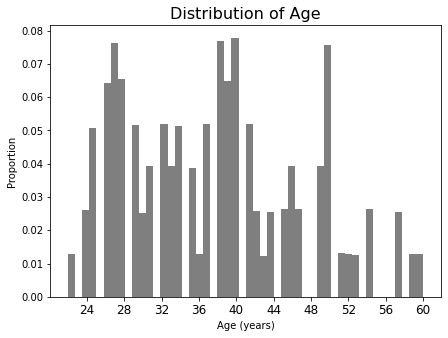

In [53]:
all_ages = final_data['age']
plt.figure(figsize = [7,5])
plt.xticks(np.arange(20,100, 4) ,fontsize=12)
# plt.yticks([])
plt.xlabel('Age (years)')
plt.ylabel('Proportion')
plt.title('Distribution of Age', fontsize=16)
_, bins, _= plt.hist(all_ages, 50, density=1, alpha=0.5, color='black')
plt.show()


In [54]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.anova import AnovaRM

def subject_pivotTable(data, duration):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each rounded actual depth the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """

    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    avg = pd.pivot_table(data,  values = ["depth_estimate"], columns=['actual_depth'], aggfunc=np.mean)
    avg.reset_index()
    avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
    std = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = np.std)
    #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
    std.reset_index()
    std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
    sem = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = 'sem')
    sem.reset_index()
    sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
    frames = [avg_renamed, std_renamed, sem_renamed] #list of pivot tables for a given duration
    result = pd.concat(frames) #merge the pivot tables for a given duration 
    result = result.T #transpose 
        
    #Label the data by duration 
    result["Duration"] = duration
    
    return result

def subject_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    """
    x = []
    y = []
    ste = []
    for idx, row in data.iterrows():
        x.append(idx) #idx is the actual depth value 
            
        estim_avg = row["Average Estimated Depth"]
        y.append(estim_avg)
            
        standard_error = row["Standard Error"]
        ste.append(standard_error)
   
    return x, y, ste 


In [83]:
def AnovaRM_subjectData(df, durations):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    
    all_subjIDs = df.subjID.unique()
    subj_slopes = {'subjID': [], 'duration': [], 'slope': [], 'age': []}
    subj_intercepts = {'subjID': [], 'duration': [], 'intercept' : [], 'age': []}

    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj] 
        for duration in durations:
            duration_subj_df = subj_df
            duration_subj_pivot = subject_pivotTable(duration_subj_df, duration)
            duration_subj_data = subject_getxy(duration_subj_pivot)

            x = np.array(duration_subj_data[0])
            y = np.array(duration_subj_data[1])
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            subj_slopes['subjID'].append(subj)
            subj_slopes['duration'].append(duration)
            subj_slopes['slope'].append(slope)
            subj_slopes['age'].append(duration_subj_df.age.unique()[0])
            
            subj_intercepts['subjID'].append(subj)
            subj_intercepts['duration'].append(duration)            
            subj_intercepts['intercept'].append(intercept)
            subj_intercepts['age'].append(duration_subj_df.age.unique()[0])
                
    slope_df = pd.DataFrame(data=subj_slopes)
    intercept_df = pd.DataFrame(data=subj_intercepts)
        
    return slope_df, intercept_df


In [84]:
zs_final_data_250 = zscored_data.loc[zscored_data["duration"]  == 250]
zs_final_data_1000 = zscored_data.loc[zscored_data["duration"]  == 1000]

In [85]:
slopes_250, df_intercept_250 = AnovaRM_subjectData(zs_final_data_250, [250])
slopes_1000, df_intercept_1000 = AnovaRM_subjectData(zs_final_data_1000, [1000])



#### Distribution of Participant Average Estimates

In [86]:
all_subjIDs = zscored_data.subjID.unique()
avgs = []
for subj in all_subjIDs:
    subj_df = zscored_data.loc[zscored_data['subjID'] == subj]
    subj_avg = np.array(subj_df['depth_estimate']).mean()
    avgs.append(subj_avg)
    if subj_avg > 11:
        print(subj)
    
# 9-6-2021_6-48-58_485648.csv
# 9-6-2021_7-13-44_277612.csv
# 9-6-2021_7-48-11_153554.csv

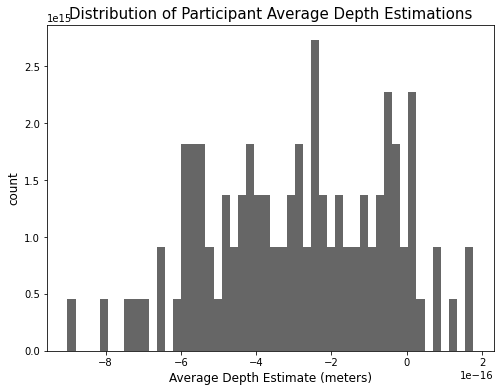

In [87]:
plt.figure(figsize = [8,6])
plt.title("Distribution of Participant Average Depth Estimations", fontsize = 15)
plt.ylabel("count", fontsize = 12)
plt.xlabel("Average Depth Estimate (meters)", fontsize = 12)
_, bins, _ = plt.hist(avgs, 50, density=1, alpha=0.6, color = 'black')
mu, sigma = scipy.stats.norm.fit(avgs)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
# plt.plot(bins, best_fit_line, color = 'orange')

plt.show()

### Data split by duration

In [99]:
data_250ms = zscored_data[zscored_data['duration'] == 250]
data_1000ms = zscored_data[zscored_data['duration'] == 1000]

duration_data = [data_250ms, data_1000ms]


In [61]:
# dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_analysis/TAC_data/matched/'
# durations = ['250', '1000']

# for i in range(len(duration_data)):  
#     duration_data[i].to_csv(dest + 'raw_' + durations[i] + '_data.csv' , index=True)
#     normalized_duration_data[i].to_csv(dest + 'normalized_' + durations[i] + '_data.csv' , index=True)

# Individual Target Results


In [109]:
def trial_pivotTable(data):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each individual target (stimulus) the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """
    
    avg_tables = []
    std_tables = []
    result_tables = []
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    cond = 0
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        actual = pd.pivot_table(duration,  values = ["actual_depth"], columns=['stimulus'], aggfunc=np.mean)
        actual.reset_index()
        actual_renamed = actual.rename(index={'actual_depth': 'Actual Depth'})
        
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['stimulus'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        RT = pd.pivot_table(duration,  values = ["trial_RT"], columns=['stimulus'], aggfunc=np.mean)
        RT.reset_index()
        RT_renamed = RT.rename(index={'trial_RT': 'Average Trial RT'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        frames = [avg_renamed, std_renamed, sem_renamed, actual_renamed, RT_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        result = result.sort_values(by=['Actual Depth'])

        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 250
        if cond == 1:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
        
    
    return result_tables

In [110]:
raw_trial_pivot = trial_pivotTable(duration_data)


In [112]:
# raw_trial_pivot[0]

In [113]:
def trial_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [250, 500, 750, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        actualdepths = [x_250, x_500, x_750, x_1000]
        xs = [list of individual targets]
        ys = [y_250, y_500, y_750, y_100]
        stes = [ste_250, ste_500, ste_750, ste_1000]
        
    """
    xs = []
    ys = []
    stes = []
    stds = []
    actualdepths = []
    trial_RTs = []
    for table in data:
        x = []
        y = []
        ste = []
        std = []
        depths = []
        RT = []
        for idx, row in table.iterrows():
            
            x.append(idx) #idx is the target (stimulus path)
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
            
            depth = row["Actual Depth"]
            depths.append(depth)
            
            standard_deviation = row["Standard Deviation"]
            std.append(standard_deviation)       
            
            reactionTime = row["Average Trial RT"]
            RT.append(reactionTime)  
            
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        actualdepths.append(depths)
        stds.append(std)
        trial_RTs.append(RT)

    return xs, ys, stes, actualdepths, stds, trial_RTs

In [114]:
trial_raw_final = trial_getxy(raw_trial_pivot)


### Raw Data

In [115]:
trial_plot_data = trial_raw_final

## Execute this cell to prep for plotting
final_x_250 = trial_plot_data[0][0]
final_y_250 = trial_plot_data[1][0]
ste_250 = trial_plot_data[2][0]
stim_250 = trial_plot_data[3][0]
std_250 = trial_plot_data[4][0]
RT_250 = trial_plot_data[5][0]

final_x_1000 = trial_plot_data[0][1]
final_y_1000 = trial_plot_data[1][1]
ste_1000 = trial_plot_data[2][1]
stim_1000 = trial_plot_data[3][1]
std_1000 = trial_plot_data[4][1]
RT_1000 = trial_plot_data[5][1]

m: [0.54873217]
b: -1.652959793305851
R-squared:  0.705689156673294


0.706

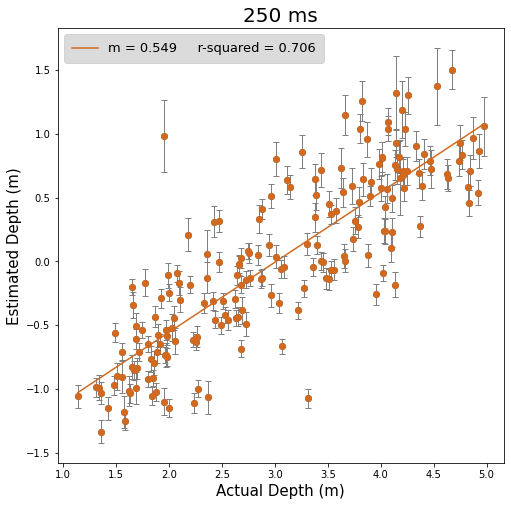

In [103]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_250 = np.array(stim_250).reshape(-1,1)
y_250 = final_y_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.plot(X_250, y_250, 'o', color='black', alpha = 0.5);
plt.plot(X_250,y_predicted_250,color='chocolate', label = 'm = ' + str(round(reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_250.score(X_250, y_250)), 3)))
plt.title("250 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
# plt.plot(X_250, X_250, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_250, y_250, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

round(float(reg_250.score(X_250, y_250)), 3)

m: [0.52716184]
b: -1.5885582686786344
R-squared:  0.7192718299446437


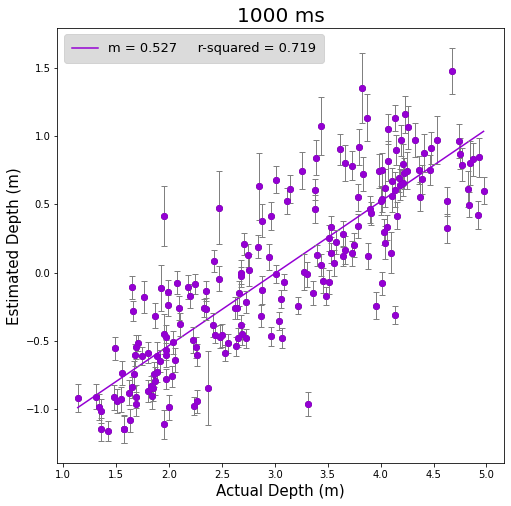

In [104]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_1000 = np.array(stim_1000).reshape(-1,1)
y_1000 = final_y_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values
plt.plot(X_1000, y_1000, 'o', color='black', alpha = 0.7);
plt.plot(X_1000,y_predicted_1000,color='darkviolet', label = 'm = ' + str(round(reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_1000.score(X_1000, y_1000)), 3)))

plt.title("1000 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
# plt.plot(X_1000, X_1000, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_1000, y_1000, yerr=ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)


legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')



#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))

m: [0.15411759]
b: -0.00021358595137555735
R-squared:  0.338812759634739


0.339

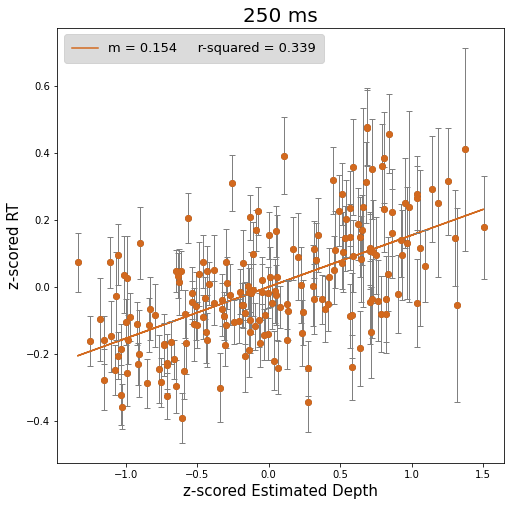

In [121]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_250 = np.array(final_y_250).reshape(-1,1)
y_250 = RT_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.plot(X_250, y_250, 'o', color='black', alpha = 0.5);
plt.plot(X_250,y_predicted_250,color='chocolate', label = 'm = ' + str(round(reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_250.score(X_250, y_250)), 3)))
plt.title("250 ms", fontsize = 20)
plt.xlabel("z-scored Estimated Depth", fontsize = 15)
plt.ylabel("z-scored RT", fontsize = 15)
plt.errorbar(X_250, y_250, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

round(float(reg_250.score(X_250, y_250)), 3)

m: [0.20984501]
b: -4.1906640186952524e-05
R-squared:  0.4386643727838815


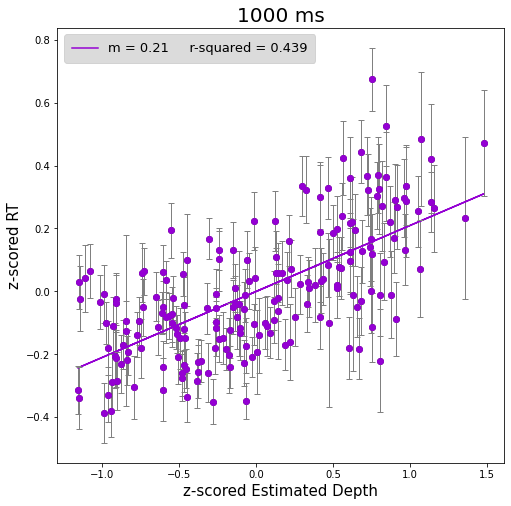

In [118]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_1000 = np.array(final_y_1000).reshape(-1,1)
y_1000 = RT_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values
plt.plot(X_1000, y_1000, 'o', color='black', alpha = 0.7);
plt.plot(X_1000,y_predicted_1000,color='darkviolet', label = 'm = ' + str(round(reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_1000.score(X_1000, y_1000)), 3)))

plt.title("1000 ms", fontsize = 20)
plt.xlabel("z-scored Estimated Depth", fontsize = 15)
plt.ylabel("z-scored RT", fontsize = 15)
# plt.plot(X_1000, X_1000, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_1000, y_1000, yerr=ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)


legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))